# Product Recognition on Store Shelves

## Overall Task

Develop a computer vision system that, given a reference image for each product, is able to identify boxes of cereals of different brands from one picture of a store shelf. For each type of product displayed in the shelf the system should report:
1. Number of instances.
2. Dimension of each instance (width and height of the bounding box that enclose them in pixel).

<img src="ImageOverall/1_ImageOverall.JPG" width="256">

3. Position in the image reference system of each instance (center of the bounding box that enclose them in pixel).

For example, as output of the above image the system should print:

<img src="ImageOverall/2_ImageOverall.JPG" width="512">

In [1]:
#Import required modules
import numpy as np
from matplotlib import pyplot as plt
import cv2
from collections import defaultdict

# Only for jupyter notebook visualization
%matplotlib inline

In [2]:
#Define functions used in the code

#function to find centroid from vertexes
def centroid(vertexes):
    x_list = [vertex [0] for vertex in vertexes]
    y_list = [vertex [1] for vertex in vertexes]
    lenght = len(vertexes)
    x = int(round(sum(x_list) / lenght))
    y = int(round(sum(y_list) / lenght))
    return(x, y)

#function to compute euclidian distance
def euclidian_distance(point_1,point_2):
    dist = np.sqrt((point_1[0]-point_2[0])**2+(point_1[1]-point_2[1])**2)
    return dist

def findmodel(i, check):
    if i == 0:
        if(check):
            print("model 0: Nesquik Cioccomilk")
        return 0, "Nesquik"
    elif i == 1:
        if(check):
            print("model 1: ChocoKrave al latte")
        return 1, "CK blue"
    elif i == 2:
        if(check):
            print("model 11: ChocoKrave Nocciole")
        return 11, "CK orange"
    elif i == 3:
        if(check):
            print("model 19: Country crisp")
        return 19, "Country crisp"
    elif i == 4:
        if(check):
            print("model 24: Fitness")
        return 24, "Fitness"
    elif i == 5:
        if(check):
            print("model 25: Coco Pops")
        return 25, "CocoPops"
    elif i == 6:
        if(check):
            print("model 26: Nesquik Duo")
        return 26,"Nesquik Duo"

In [3]:
#function to build r table based on model keypoints
def build_r_table(barycentre, src_vector):
    r_table = defaultdict(list)
    for k in range(len(src_vector)):
        j,i=src_vector[k,0]
        r_table[k].append((barycentre[0]-i, barycentre[1]-j, src_vector[k,1]))
    return r_table

#function to cast votes for barycentre position
def accumulate_kp(r_table, Shelf_Image, dst_vector):
    accumulator = np.zeros(Shelf_Image.shape)
    counter=0
    for k in range(len(dst_vector)):
        counter+=1
        j,i=dst_vector[k,0]
        new_size=dst_vector[k,1]
        #each model keypoint has 3 associated scene keypoints
        if(counter==1):
            index=k/3
        #access to corrispondent keypoint of the model
        for r in r_table[index]:
            ratio=new_size/r[2]
            #find new barycentre
            accum_i, accum_j = int(round(i+ratio*r[0])), int(round(j+ratio*r[1]))
            if (0<accum_i < accumulator.shape[0] and 0<accum_j < accumulator.shape[1]):
                accumulator[accum_i, accum_j] += 1
        if(counter==3):
            counter=0
    return accumulator

#function to plot accumulator on a white image and find possible barycentre candidates
def plot_accumulator(accumulator, shelf_image):
    barycentres=[]
    row, col = accumulator.shape
    white = shelf_image.copy()
    white.fill(255)
    #print("image shape: ", white.shape)
    for i in range(row):
        for j in range(col):
            r = 10 
            if(accumulator[i,j]>0):
                white[i,j] = 0
            if(accumulator[i,j]>2):
                if (i + r > row):
                    r = row - i
                elif (i - r <= 0):
                    r = i
                if (j + r > col):
                    r = col - j
                elif (j - r <= 0):
                    r = j

                for k in range(-r+1,r-1):
                    white[i+k,j + k] = 0
                    white[i + k,j - k] = 0
                barycentres.append([i,j])
    plt.figure(figsize=(20, 10))
    plt.imshow(white, cmap='gray', vmin=0, vmax=255)
    plt.show()
    return barycentres

#function to filter a barycentres list making mean between closest ones
def distance_filter(barycentres, chosen_distance):
    filtered_bar = []
    L=len(barycentres)
    for first in range(L):
        if (barycentres[first] != [0,0]):
            sum_b = barycentres[first].copy()
            count_b = 1
            next_index=first+1
            for second in range(next_index,L):
                dist = euclidian_distance(barycentres[first],barycentres[second])
                if(dist<chosen_distance and barycentres[second] != [0,0]):
                    sum_b[0] = sum_b[0]+barycentres[second][0]
                    sum_b[1] = sum_b[1]+barycentres[second][1]
                    barycentres[second] = [0,0]
                    count_b += 1

                if second == L-1:
                    sum_b[0] = int(round(sum_b[0] / count_b))
                    sum_b[1] = int(round(sum_b[1] / count_b))
                    filtered_bar.append(sum_b)
    return filtered_bar

#function to filter barycentres list according to votes in their neighbourhood
def neighborhood_filter(filtered_bar, accumulator, LIMIT, BOUND):
    
    row, col = accumulator.shape
    removed_bar = []
    count = 0
    L_f=len(filtered_bar)
    
    for k in range(L_f):
        start_row = filtered_bar[k][0] - LIMIT
        start_col = filtered_bar[k][1] - LIMIT
        end_row = filtered_bar[k][0] + LIMIT
        end_col = filtered_bar[k][1] + LIMIT

        if (end_row > row):
            end_row = row
        if (start_row < 0):
            start_row = 0

        if (end_col > col):
            end_col = col
        if (start_col < 0):
            start_col = 0

        for i in range(start_row, end_row):
            for j in range(start_col, end_col):
                if (accumulator[i, j] > 1):
                    count = count + accumulator[i, j]
        #print(filtered_bar[k], count)
        if count < BOUND:
            removed_bar.append(filtered_bar[k])
        count = 0
        
    for i in removed_bar:
        filtered_bar.remove(i)
    
    return filtered_bar

#function to visualize found barycentres
def plot_filtered_bar(accumulator, shelf_image, filtered_bar):
    if filtered_bar == []:
        print("There is no Barycenter")
        return None
    else:
        white = shelf_image.copy()
        white.fill(255)# or img[:] = 255
        row, col = accumulator.shape

        for l in filtered_bar:
            i = l[0]
            j = l[1]
            cv2.rectangle(white,(j-10, i-10), (j+10, i+10) , (0,0,0), cv2.FILLED)
  
        print("There are {} Barycenter(s)".format(len(filtered_bar)))
        plt.figure(figsize=(20, 10))
        plt.imshow(white, cmap='gray', vmin=0, vmax=255)
        plt.show()
    return None

#function to isolate keypoints which casted a "correct" vote
def find_correct_keypoints(bar_found, dst_train_vector, r_table, good, Shelf_Image, LIMIT):
    good_kp=[]
    final_good=[]
    counter=0
    for k in range(len(dst_train_vector)):
        counter+=1
        j,i=dst_train_vector[k,0]
        new_size=dst_train_vector[k,1]
        if(counter==1):
            index=k/3
        for r in r_table[index]:
            #access to vectors of corresponding kp
            ratio=new_size/r[2]
            bar_i, bar_j = int(round(i+ratio*r[0])), int(round(j+ratio*r[1]))
            if (0< bar_i < Shelf_Image.shape[0] and 0<bar_j < Shelf_Image.shape[1]):
                if(bar_found[0]-LIMIT<bar_i<bar_found[0]+LIMIT)and(bar_found[1]-LIMIT<bar_j<bar_found[1]+LIMIT):
                    good_kp=good[k]
                    final_good.append(good_kp)
        if(counter==3):
            counter=0
    return final_good

In [4]:
#Step A and B
#Offline phase: model acquisition 
# {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}
# model[0] --> 0.jpg
# model [1] --> 1.jpg
# model [2] --> 11.jpg
# ...

query_img = []
query_img.append(cv2.imread("models/0.jpg"))
query_img.append(cv2.imread("models/1.jpg")) 
query_img.append(cv2.imread("models/11.jpg")) 
query_img.append(cv2.imread("models/19.jpg")) 
query_img.append(cv2.imread("models/24.jpg")) 
query_img.append(cv2.imread("models/25.jpg")) 
query_img.append(cv2.imread("models/26.jpg"))

#conversion to original colours
model = [cv2.cvtColor(query_img[i],cv2.COLOR_BGR2RGB) for i in range(0,7)]
#gray version of the image
model_gray = [cv2.cvtColor(query_img[i],cv2.COLOR_BGR2GRAY) for i in range(0,7)]

# Getting the first axis, Red
R_model = [model[i][:,:,0] for i in range(0,7)]

# Getting the second axis, Green
G_model = [model[i][:,:,1] for i in range(0,7)]

# Getting the third axis, Blue
B_model = [model[i][:,:,2] for i in range(0,7)]

#to show the model images axes
#for i in range(0,7):
#    findmodel(i,True)
#    plt.imshow(R[i], cmap='gray', vmin=0, vmax=255)
#    plt.show()
#    plt.imshow(G[i], cmap='gray', vmin=0, vmax=255)
#    plt.show()
#    plt.imshow(B[i], cmap='gray', vmin=0, vmax=255)
#    plt.show()

model 0: Nesquik Cioccomilk
[192, 177, 132]


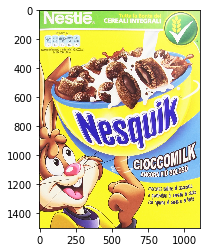

model 1: ChocoKrave al latte
[130, 132, 126]


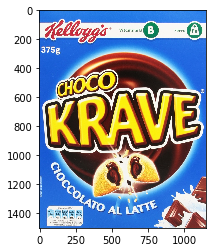

model 11: ChocoKrave Nocciole
[185, 123, 55]


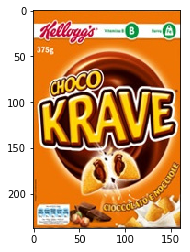

model 19: Country crisp
[111, 114, 114]


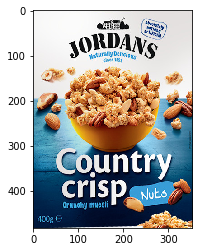

model 24: Fitness
[184, 163, 185]


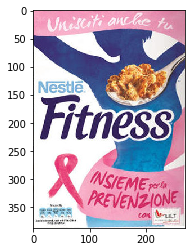

model 25: Coco Pops
[174, 117, 120]


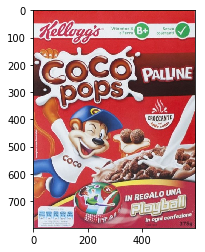

model 26: Nesquik Duo
[200, 142, 102]


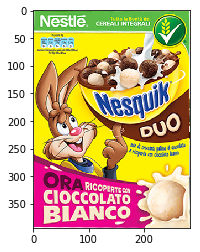

In [5]:
#Find a reference colour (mean colour of a given area)
ref_colour=[[]]*7

for i in range(0,7):
    start_row = int(model[i].shape[0]/3)
    to_do_mean = model[i][start_row: model[i].shape[0], 0:model[i].shape[1]]
    mean_model = np.mean(to_do_mean, axis=(0, 1))
    ref_colour[i] = mean_model.astype(int).tolist()

#Show model images
for i in range(0,7):
    findmodel(i,True)
    print(ref_colour[i])
    plt.imshow(model[i], cmap='gray', vmin=0, vmax=255)
    plt.show()

In [6]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints with SIFT im model images, one for each channel
kp_model_1 = [sift.detect(R_model[i]) for i in range(0,7)]
kp_model_2 = [sift.detect(G_model[i]) for i in range(0,7)]
kp_model_3 = [sift.detect(B_model[i]) for i in range(0,7)]

# Describing keypoints
kp_des_model_1=[[]]*7
kp_des_model_2=[[]]*7
kp_des_model_3=[[]]*7

for i in range(0,7):
    kp_model_1[i], kp_des_model_1[i] = sift.compute(R_model[i], kp_model_1[i])
    kp_model_2[i], kp_des_model_2[i] = sift.compute(G_model[i], kp_model_2[i])
    kp_model_3[i], kp_des_model_3[i] = sift.compute(B_model[i], kp_model_3[i])

In this part we can select a specific scene to analyse.

Available scenes are: 

e1, e2, e3, e4, e5 [step A]

m1, m2, m3, m4, m5 [step B]

In [115]:
scene_chosen = input("Choose a scene among available ones and press Enter:  ")

Choose a scene among available ones and press Enter:  m5


scenes/m5.png


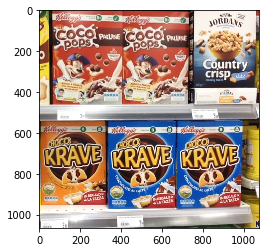

In [116]:
dirname = "scenes/"
img_name = dirname + scene_chosen + ".png"

print(img_name)

#Read the scene image
img_train = cv2.imread(img_name)

#conversion to original colours
scene = cv2.cvtColor(img_train,cv2.COLOR_BGR2RGB)
#gray version of the image
scene_gray = cv2.cvtColor(img_train, cv2.COLOR_BGR2GRAY)


#Code in order to show the train image
plt.imshow(scene, cmap='gray', vmin=0, vmax=255)
plt.show()

# Getting the first axis, Red
R_scene = scene[:,:,0]

# Getting the second axis, Green
G_scene = scene[:,:,1]

# Getting the third axis, Blue
B_scene = scene[:,:,2]

#to show the scene axes
#plt.imshow(R_scene, cmap='gray', vmin=0, vmax=255)
#plt.show()
#plt.imshow(G_scene, cmap='gray', vmin=0, vmax=255)
#plt.show()
#plt.imshow(B_scene, cmap='gray', vmin=0, vmax=255)
#plt.show()

In [117]:
# find the keypoints with SIFT for each channel
kp_scene_1 = sift.detect(R_scene)
kp_scene_2 = sift.detect(G_scene)
kp_scene_3 = sift.detect(B_scene)

# Describing keypoints for scene image
kp_scene_1, kp_des_scene_1 = sift.compute(R_scene,kp_scene_1)
kp_scene_2, kp_des_scene_2 = sift.compute(G_scene,kp_scene_2)
kp_scene_3, kp_des_scene_3 = sift.compute(B_scene,kp_scene_3)

In [118]:
#consider all keypoints among channels
kp_model=[[]]*7
for i in range(0,7):
    all_in=kp_model_1[i]+kp_model_2[i]+kp_model_3[i]
    kp_model[i]=all_in.copy()

kp_scene=kp_scene_1+kp_scene_2+kp_scene_3

In [119]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 50)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [120]:
matches_list=[[]]*7
total_matches_list=[[]]*7
src_pts_matches=[[]]*7
dst_pts_matches=[[]]*7
r_table=[[]]*7
accumulator=[[]]*7

for i in range(0,7):
    # Matching and finding the 3 closest elements for each query descriptor in each channel.
    matches_1 = flann.knnMatch(kp_des_model_1[i],kp_des_scene_1,k=3)
    matches_2 = flann.knnMatch(kp_des_model_2[i],kp_des_scene_2,k=3)
    matches_3 = flann.knnMatch(kp_des_model_3[i],kp_des_scene_3,k=3)

    matches_list[i]=matches_1+matches_2+matches_3

    total_match=[]
    for m,n,o in matches_list[i]:
        total_match.append(m)
        total_match.append(n)
        total_match.append(o)
    total_matches_list[i]=total_match.copy()
    #...
    #find coordinates and size of the matched keypoints(both model and scene)
    src_pts_matches[i] = np.array([(kp_model[i][total_match[m].queryIdx].pt,kp_model[i][total_match[m].queryIdx].size) for m in range(0, len(total_match),3)])
    dst_pts_matches[i] = np.array([(kp_scene[total_match[m].trainIdx].pt,kp_scene[total_match[m].trainIdx].size) for m in range(len(total_match))])
    
    print(len(src_pts_matches[i]), len(dst_pts_matches[i]))

24151 72453
10843 32529
1131 3393
3863 11589
2828 8484
9809 29427
3251 9753


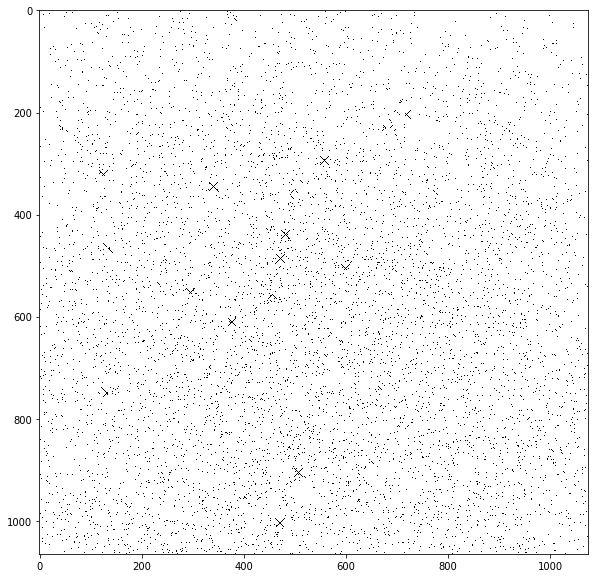

[[10, 553], [119, 869], [202, 387], [204, 718], [235, 682], [294, 558], [322, 126], [345, 341], [361, 489], [439, 482], [466, 135], [486, 472], [506, 599], [553, 296], [556, 456], [610, 377], [624, 239], [749, 133], [905, 507], [1004, 471], [1058, 287]]


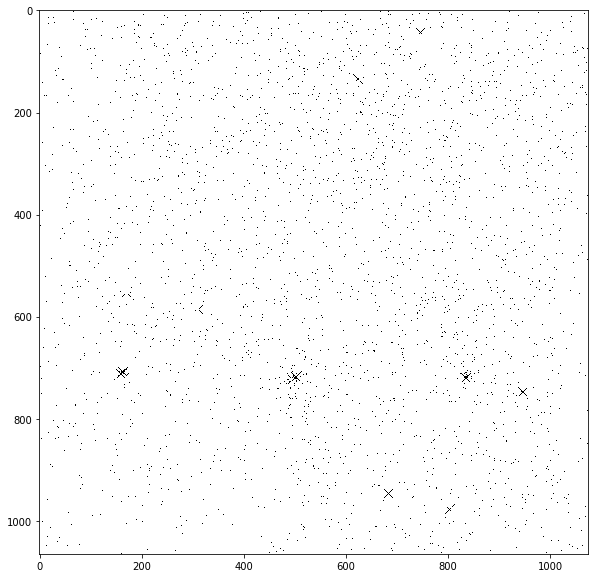

[[44, 746], [135, 624], [552, 171], [586, 311], [708, 164], [709, 164], [710, 161], [711, 166], [712, 160], [712, 836], [716, 503], [716, 836], [717, 502], [718, 502], [719, 502], [720, 503], [720, 835], [721, 504], [723, 496], [747, 946], [766, 471], [766, 498], [946, 683], [977, 803]]


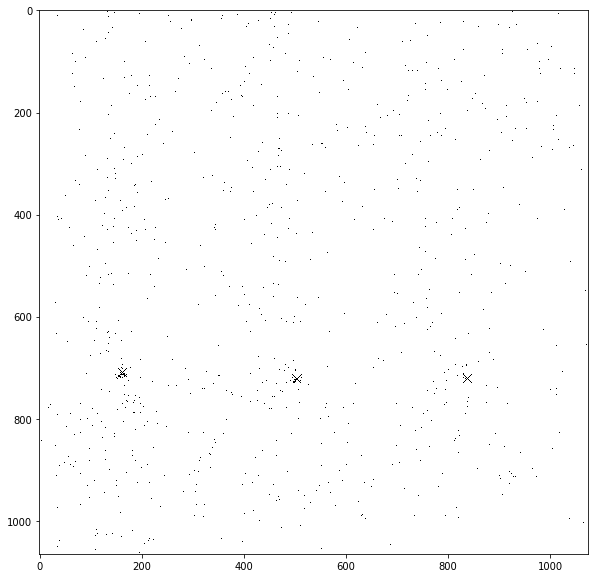

[[709, 163], [713, 160], [719, 835], [721, 838], [722, 503], [722, 504], [765, 165]]


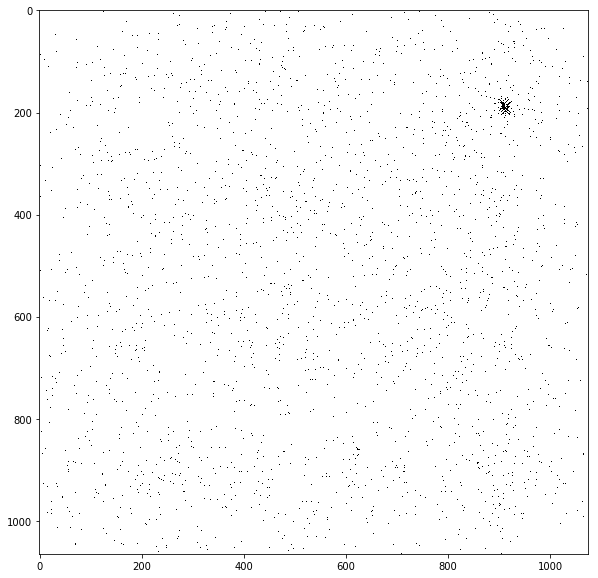

[[184, 909], [188, 908], [189, 914], [190, 911], [190, 912], [196, 912], [196, 913], [492, 123], [865, 630], [1002, 100]]


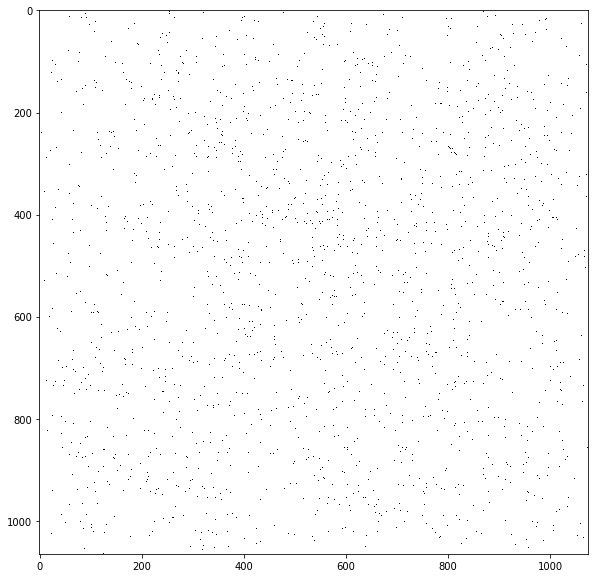

[[251, 365], [275, 809]]


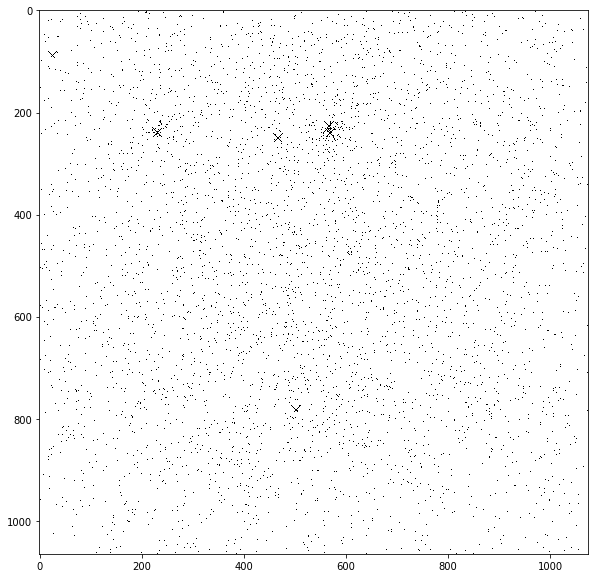

[[89, 26], [160, 282], [204, 240], [222, 240], [223, 235], [227, 567], [228, 575], [231, 564], [239, 231], [240, 569], [250, 467], [469, 515], [783, 502], [824, 38]]


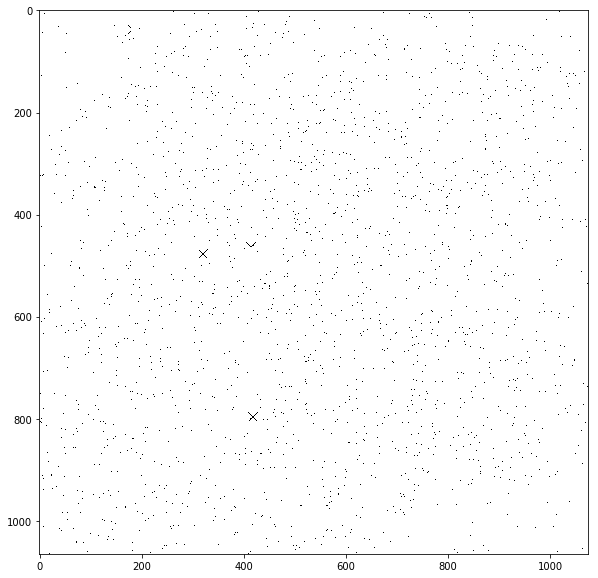

[[38, 183], [464, 414], [477, 320], [796, 418]]


In [121]:
barycentres_list=[[]]*7

#build r_table and accumulator to find barycentres
for i in range(0,7):
    model_bar=(int(model_gray[i].shape[0]/2), int(model_gray[i].shape[1]/2))
    r_table[i]=build_r_table(model_bar,src_pts_matches[i])
    accumulator[i]=accumulate_kp(r_table[i],scene_gray,dst_pts_matches[i])
    
    #visual seen of accumulator + possibile barycentres idetification
    barycentres_list[i]=plot_accumulator(accumulator[i], scene_gray)
    print(barycentres_list[i])

In [122]:
# Zero filter
zero_filtered_bar=[[]]*7
for i in range(0,7):
    zero_filtered_bar[i]=neighborhood_filter(barycentres_list[i],accumulator[i],15, 20)

# First filter on barycentres
first_filtered_bar=[[]]*7
for i in range(0,7):
    first_filtered_bar[i]=distance_filter(zero_filtered_bar[i],100)
    
    

[]
model 0: Nesquik Cioccomilk
There is no Barycenter
[[710, 163], [716, 836], [719, 502]]
model 1: ChocoKrave al latte
There are 3 Barycenter(s)


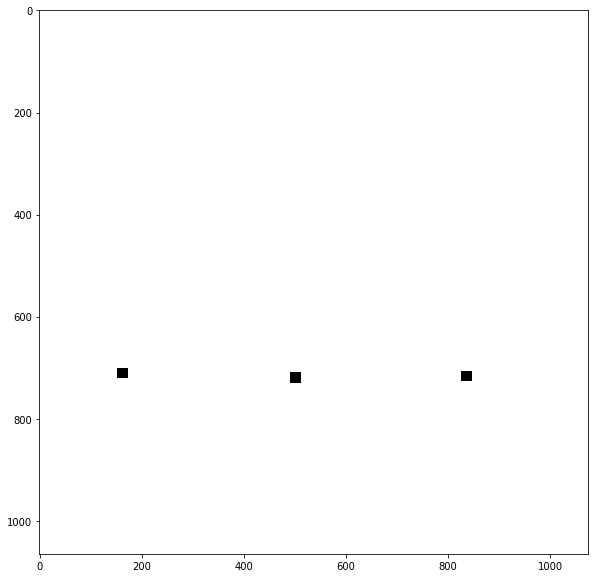

[[711, 162], [722, 504]]
model 11: ChocoKrave Nocciole
There are 2 Barycenter(s)


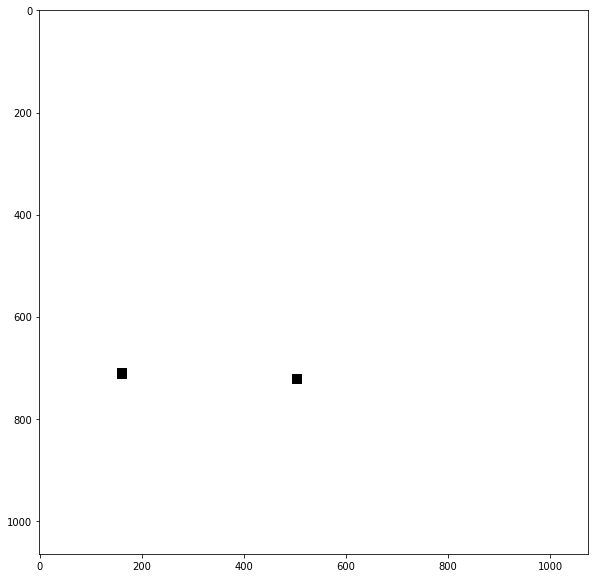

[[190, 911]]
model 19: Country crisp
There are 1 Barycenter(s)


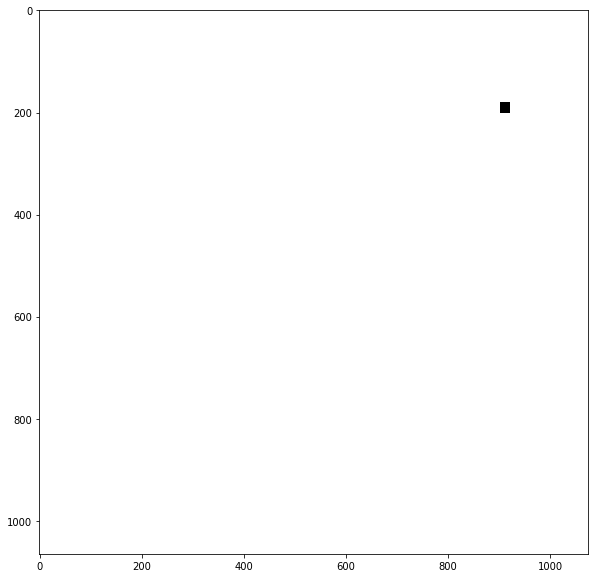

[]
model 24: Fitness
There is no Barycenter
[[228, 235], [232, 569]]
model 25: Coco Pops
There are 2 Barycenter(s)


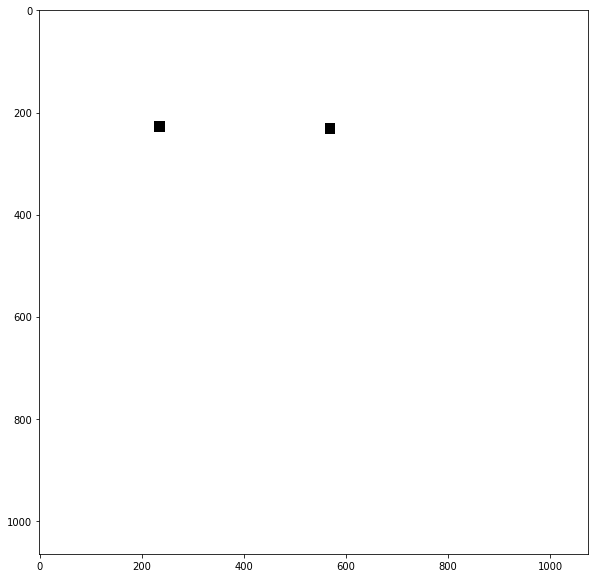

[]
model 26: Nesquik Duo
There is no Barycenter


In [123]:
#second filter
second_filtered_bar=[[]]*7

for i in range(0,7):
    second_filtered_bar[i]=neighborhood_filter(first_filtered_bar[i],accumulator[i],35, 27)
    print(second_filtered_bar[i])
    
    #Plot the Barycenters
    findmodel(i, True)
    plot_filtered_bar(accumulator[i], scene_gray, second_filtered_bar[i])
    

In [124]:
#Find now the right "good" vectors

final_good=[[]]*7
model_draw_kp=[[]]*7

for j in range(7):
    final_good[j]=[[]]*len(second_filtered_bar[j])
    for i in range(len(second_filtered_bar[j])):
        final_good[j][i]=find_correct_keypoints(second_filtered_bar[j][i],dst_pts_matches[j],r_table[j],total_matches_list[j],scene_gray, 30)

In [125]:
#create a copy of the image on which we can work
per_check=[]

for i in range(7):
    n_model, name_model = findmodel(i,True)
    
    for k in range(len(second_filtered_bar[i])):
        # Checking if we found enough matching
        MIN_MATCH_COUNT = 50
    
        if (len(final_good[i][k])>MIN_MATCH_COUNT):
            # building the corrspondences arrays of good matches
            print( "matches are found - {}/{}".format(len(final_good[i][k]),MIN_MATCH_COUNT))
            src_pts = np.float32([ kp_model[i][m.queryIdx].pt for m in final_good[i][k]]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in final_good[i][k]]).reshape(-1,1,2)
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.5)
            #M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_REPROJ_THRESHOLD)
            # Mask of discarded point used in visualization
            matchesMask = mask.ravel().tolist()

            # Corners of the query image
            h,w = model[i].shape[0], model[i].shape[1]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            #print(pts)


            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)
            width = int(round(dst[2,0][0] - dst[0,0][0]))
            height = int(round(dst[1,0][1] - dst[0,0][1]))
            lower_width = int(round(dst[3,0][0] - dst[1,0][0]))
            lower_height = int(round(dst[2,0][1] - dst[3,0][1]))
            if ((abs(dst[0,0][0]-dst[1,0][0])<30) and abs(dst[0,0][1]-dst[3,0][1])<30 
                and abs(dst[2,0][0]-dst[3,0][0])<30 and abs(dst[1,0][1]-dst[2,0][1])<30):
    
                #if dealing with chocokrave (correct model)
                if (n_model == 1 or n_model==11):
                    dst= np.int32(dst)+(0,30)
                    
                #control over the colour of a significant area   
                x_1=int((dst[0,0][0]+dst[1,0][0])/2)
                if(x_1<0):
                    x_1=0
                if(x_1>=scene.shape[1]):
                    x_1=scene.shape[1]-1
                y_1=int((dst[0,0][1]+dst[3,0][1])/2)
                if(y_1<0):
                    y_1=0
                if(y_1>=scene.shape[0]):
                    y_1=scene.shape[0]-1
                x_2=int((dst[2,0][0]+dst[3,0][0])/2)
                if(x_2<0):
                    x_2=0
                if(x_2>=scene.shape[1]):
                    x_2=scene.shape[1]-1
                y_2=int((dst[1,0][1]+dst[2,0][1])/2)
                if(y_2<0):
                    y_2=0
                if(y_2>=scene.shape[0]):
                    y_2=scene.shape[0]-1
                
                y_aux = int(y_1+(y_2-y_1)/3)
                to_do_mean = scene[y_aux:y_2, x_1:x_2]
                mean_scene = np.mean(to_do_mean, axis=(0, 1))
                accum_area = mean_scene.astype(int).tolist()
                
                #print(accum_area, ref_colour[i])
                
                color_first=abs(ref_colour[i][0]-accum_area[0])
                color_second=abs(ref_colour[i][1]-accum_area[1])
                color_third=abs(ref_colour[i][2]-accum_area[2])

                #check on colour mean
                if(color_first<33 and color_second<33 and color_third <33 and  color_first+color_second+color_third<60):
    
                    perimeter=width+lower_width+height+lower_height
                    #print(perimeter)
                    per_check.append((i,perimeter, dst))
        else:
            print( "Not enough matches are found - {}/{}".format(len(final_good[i][k]), MIN_MATCH_COUNT))
            matchesMask = None              

model 0: Nesquik Cioccomilk
model 1: ChocoKrave al latte
matches are found - 114/50
matches are found - 143/50
matches are found - 198/50
model 11: ChocoKrave Nocciole
matches are found - 114/50
matches are found - 88/50
model 19: Country crisp
matches are found - 289/50
model 24: Fitness
model 25: Coco Pops
matches are found - 229/50
matches are found - 219/50
model 26: Nesquik Duo


model 1: ChocoKrave al latte
Position:  (832, 745) Width:  298 px Height:  419 px
Position:  (500, 754) Width:  317 px Height:  415 px
number of instances: 2
model 11: ChocoKrave Nocciole
Position:  (164, 744) Width:  312 px Height:  401 px
number of instances: 1
model 19: Country crisp
Position:  (908, 190) Width:  291 px Height:  390 px
number of instances: 1
model 25: Coco Pops
Position:  (235, 228) Width:  332 px Height:  465 px
Position:  (566, 227) Width:  316 px Height:  450 px
number of instances: 2


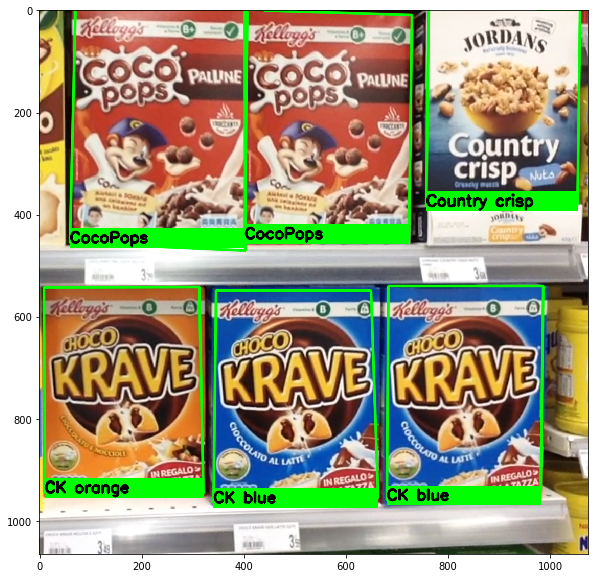

In [126]:
scene_copy = np.copy(scene)

#find average between perimeters
mean_perimeters=0
counter=0
for j in range(len(per_check)):
    mean_perimeters+=per_check[j][1]
    counter+=1
mean_perimeters=mean_perimeters/counter

n_instances=0
    
for i in range(7):
    if(i!=0 and n_instances!=0):
        print('number of instances:', n_instances)
    n_instances=0
    n_model, name_model = findmodel(i,False)
    for j in range(len(per_check)):
        #discard disproportionate boxes
        if(per_check[j][0]==i and 0.85*mean_perimeters<per_check[j][1]<1.2*mean_perimeters):
            # Drawing the bounding box
            dst=per_check[j][2]
            cv2.polylines(scene_copy,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)

            # Drawing the centre
            polygon_data = (dst[0,0]),(dst[1,0]), (dst[2,0]),(dst[3,0])
            centre=centroid(polygon_data)
            #cv2.circle(img_train_copy, centre, 10, (0,0,255), 2)

            #Draw a diagonal blue line with thickness of 5 px
            #img_train_copy=cv2.line(img_train_copy,tuple(dst[0,0]),tuple(dst[2,0]),(0,255,0),5)
            #img_train_copy=cv2.line(img_train_copy,tuple(dst[1,0]),tuple(dst[3,0]),(0,255,0),5)

            #Draw a target
            font = cv2.FONT_HERSHEY_SIMPLEX
            text = name_model
            font_scale=1.0
            (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=3)[0]
            # make the coords of the box with a small padding and then put the text
            offset_1=(int(dst[1,0][0]), int(dst[1,0][1])+10)
            offset_2=(int(dst[2,0][0]), int(dst[1,0][1])-text_height-5)
            width = int(round(dst[2,0][0] - dst[0,0][0]))
            height = int(round(dst[1,0][1] - dst[0,0][1]))
            cv2.rectangle(scene_copy,offset_1, offset_2 , (0,255,0), cv2.FILLED)
            cv2.putText(scene_copy,text,tuple(dst[1,0]), font, font_scale,(0,0,0),3,cv2.LINE_AA)
            if(n_instances==0):
                findmodel(i,True)
            print("Position: ", centre, "Width: ", width, "px Height: ", height, "px")
            n_instances+=1
if(n_instances!=0):
    print('number of instances:', n_instances)
plt.figure(figsize=(20, 10))
plt.imshow(scene_copy)
plt.show()